<a href="https://colab.research.google.com/github/rohaan-ahmed/Master-Repository/blob/master/Anomaly%20Detection/LSTM_Autoencoder_for_Video_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-layer-normalization

In [ ]:
# imports

from os import listdir
from os.path import isfile, join, isdir
from PIL import Image as PIL_Image
import numpy as np
import shelve
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML, Image, IFrame

import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras_layer_normalization import LayerNormalization

In [ ]:
class Config:
  DATASET_PATH ="/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/Train"
  PICKLED_SINGLE_TEST_ITEM = 2 # The X in Test00X
  PICKLED_SINGLE_TRAIN_ITEM = 2 # The X in Train00X
  SINGLE_TEST_PATH = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/Test/Test" + str(PICKLED_SINGLE_TEST_ITEM).rjust(3,'0')
  SINGLE_TRAIN_PATH = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/Train/Train" + str(PICKLED_SINGLE_TRAIN_ITEM).rjust(3,'0')
  BATCH_SIZE = 1
  EPOCHS = 100
  MODEL_PATH = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/saved_models/model_pretrained.hdf5"
  VIDEO_PATH = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/videos"
  TRAIN_DATA_DIRECTORY = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/Train/"
  TEST_DATA_DIRECTORY = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/Test/"
  PICKLED_TEST_SCORES = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/test_score_matrix.pkl"
  PICKLED_TRAIN_SCORES = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/train_score_matrix.pkl"
  PICKLED_TEST_COSTS = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/test_sequences_reconstruction_cost_matrix.pkl"
  PICKLED_TRAIN_COSTS = "/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/train_sequences_reconstruction_cost_matrix.pkl"

In [ ]:

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0 
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    i = 0
    for f in sorted(listdir(Config.DATASET_PATH)):
      print(listdir(Config.DATASET_PATH))
      i += 1
      if (i > 10):
        break
      if isdir(join(Config.DATASET_PATH, f)):
          all_frames = []
          # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
          for c in sorted(listdir(join(Config.DATASET_PATH, f))):
              if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "png":
                  img = PIL_Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                  img = np.array(img, dtype=np.float32) / 256.0
                  all_frames.append(img)
          print(len(all_frames))
          # get the 10-frames sequences from the list of images after applying data augmentation
          for stride in range(1, 3):
              clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips


In [ ]:
# Defining the model, training it, and saving it for future use

def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        # When model has been previously trained, simply reload the model instead of defining and training it
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
        
    else:
        # When model has been not previously trained, define, train, and save it for future use
        training_set = get_training_set()
        training_set = np.array(training_set)
        training_set = training_set.reshape(-1,10,256,256,1)
        seq = Sequential()
        #seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
        seq.add(TimeDistributed(Conv2D(64, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
        seq.add(LayerNormalization())
        seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
        seq.add(LayerNormalization())
        # # # # #
        seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
        seq.add(LayerNormalization())
        seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
        seq.add(LayerNormalization())
        seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
        seq.add(LayerNormalization())
        # # # # #
        seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
        seq.add(LayerNormalization())
        # seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
        seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
        seq.add(LayerNormalization())
        seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
        print(seq.summary())
        es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) 
        model_filepath = Config.MODEL_PATH
        save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min')
        seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), metrics=['accuracy'])
        print('training set length ' + str(len(training_set)))
        seq.fit(training_set, training_set,
                batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False, callbacks=[es, save_best])
        seq.save(Config.MODEL_PATH)
        return seq

In [ ]:
# This function is used by calculate_test_prediction_scores and calculate_train_prediction_scores to generate sequences for a given scene

def get_next_test(test_path):
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(test_path)):
        if str(join(test_path, f))[-3:] == "png":
            img = PIL_Image.open(join(test_path, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [ ]:
# This function calculates the prediction score of all test-set scenes, and saves it for future use

def calculate_test_prediction_scores():
  print("Test Predictions")

  test_directory = Config.TEST_DATA_DIRECTORY
  reconstructed_sequences_array = []
  sequences_array = []
  sr_array = []
  sequences_reconstruction_cost_array = []

  model = get_model(False)
  print("Acquired Model")

  for f in sorted(listdir(test_directory)):
    test = get_next_test(test_directory + f)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("Acquired Test Data: %s" % f)
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=2)
    print("Prediction for Test Data: %s Completed" % f)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    print("Test Data %s Score Generated" % f)
    sequences_reconstruction_cost_array.append(sequences_reconstruction_cost)
    # sequences_array.append(sequences)
    sr_array.append(sr)

    with open("/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/test_score_matrix.pkl", 'wb') as handle:
      pickle.dump(sr_array, handle)

    with open("/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/test_sequences_reconstruction_cost_matrix.pkl", 'wb') as handle:
      pickle.dump(sequences_reconstruction_cost_array, handle)
    
    print("Completed Test Data %s" % f)

In [ ]:
# This function calculates the prediction score of all training-set scenes, and saves it for future use

def calculate_train_prediction_scores():
  print("Train Predictions")

  train_directory = Config.TRAIN_DATA_DIRECTORY
  reconstructed_sequences_array = []
  sequences_array = []
  sr_array = []
  sequences_reconstruction_cost_array = []

  model = get_model(False)
  print("Acquired Model")


  for f in sorted(listdir(train_directory)):
    test = get_next_test(train_directory + f)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("Acquired Train Data: %s" % f)
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=2)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    sequences_reconstruction_cost_array.append(sequences_reconstruction_cost)
    # sequences_array.append(sequences)
    sr_array.append(sr)

    with open("/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/train_score_matrix.pkl", 'wb') as handle:
      pickle.dump(sr_array, handle)

    with open("/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/train_sequences_reconstruction_cost_matrix.pkl", 'wb') as handle:
      pickle.dump(sequences_reconstruction_cost_array, handle)
    
    print("Predicted Train Data: %s" % f)

In [ ]:
# This function generates the sequences required to evaluate the model on a single input scene. Can specify whether to use Train or Test dataset

def generate_sequences_for_single_item(item_type = 'test'):
  if item_type == 'test':
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "png":
            img = PIL_Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
  else: # item type is train
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TRAIN_PATH)):
        if str(join(Config.SINGLE_TRAIN_PATH, f))[-3:] == "png":
            img = PIL_Image.open(join(Config.SINGLE_TRAIN_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
  
  return test

In [ ]:
# Evaluate the model on a single Test scene

def evaluate_single_test(recalculate_score = False):
    model = get_model(False) # False = Load Model, True = Retrain Model
    print("Acquired Model")
    test = generate_sequences_for_single_item(item_type = 'test')
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    reconstructed_sequences = model.predict(sequences,batch_size=4)
    print("Acquired Single Test Data")

      # get the reconstruction cost of all the sequences
    if (recalculate_score == True):
      sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
      sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
      sr = 1.0 - sa
    else:
      with open(Config.PICKLED_TEST_SCORES, "rb") as file:
        print('Opened: ' + Config.PICKLED_TEST_SCORES)
        test_scores = pickle.load(file)
      sr = test_scores[Config.PICKLED_SINGLE_TEST_ITEM-1]

    return reconstructed_sequences, sequences, sr


In [ ]:
# Evaluate the model on a single Test scene

def evaluate_single_train(recalculate_score = False):
    model = get_model(False) # False = Load Model, True = Retrain Model
    print("Acquired Model")
    test = generate_sequences_for_single_item(item_type = 'train')
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    reconstructed_sequences = model.predict(sequences,batch_size=4)
    print("Acquired Single Test Data")
    # get the reconstruction cost of all the sequences
    if (recalculate_score == True):
      sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
      sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
      sr = 1.0 - sa
    else:
      with open(Config.PICKLED_TRAIN_SCORES, "rb") as file:
        print('Opened: ' + Config.PICKLED_TRAIN_SCORES)
        test_scores = pickle.load(file)
      sr = test_scores[Config.PICKLED_SINGLE_TRAIN_ITEM-1]

    return reconstructed_sequences, sequences, sr

In [ ]:
def plot_combined(reconstructed_sequences, sequences, regularity_score, save = True, title = 'combined_test_video.mp4'):
  fig5, (ax1, ax2, ax3) = plt.subplots(3)

  fig5.set_figheight(17)
  fig5.set_figwidth(15)

  ax1.set_ylabel('Reconstructed')
  ax1.set_xlabel('Frame %s' % 0)
  ax2.set_ylabel('Original')
  ax2.set_xlabel('Frame %s' % 0)
  ax3.set_ylabel('Score')
  ax3.set_xlabel('Frame %s' % 0)
  ax3.set_ylim([0.75, 1])

  ims_o = ax1.imshow(sequences[0,0,:,:,0])
  ims_r = ax2.imshow(reconstructed_sequences[0,0,:,:,0])

  regularity_score.reshape(1,-1)
  x = np.arange(0, len(regularity_score), 1)
  line, = ax3.plot(x, np.around(regularity_score, decimals=3))

  def animate(i):
      line.set_ydata(np.around(regularity_score[0:i], decimals=3))  # update the data. 
      line.set_xdata(x[0:i])  # update the data.
      ims_o.set_data(sequences[i,0,:,:,0])
      ims_r.set_data(reconstructed_sequences[i,0,:,:,0])  # update the data
      ax1.set_xlabel('Frame %s' % i)
      ax2.set_xlabel('Frame %s' % i)
      ax3.set_xlabel('Frame %s' % i)
      return line, ims_o, ims_r,

  ani5 = animation.FuncAnimation(fig5, animate, interval=50, save_count = len(regularity_score), blit=True, repeat = True)

  if (save == True):
    ani5.save(Config.VIDEO_PATH + "/" + title)
  
  return ani5.to_html5_video()

In [ ]:
reconstructed_sequences_train, sequences_train, regularity_score_train = evaluate_single_train(recalculate_score = False)

Acquired Model
Acquired Single Test Data
Opened: /content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/train_score_matrix.pkl


PLOT OF A SAMPLE TRAINING SCENE


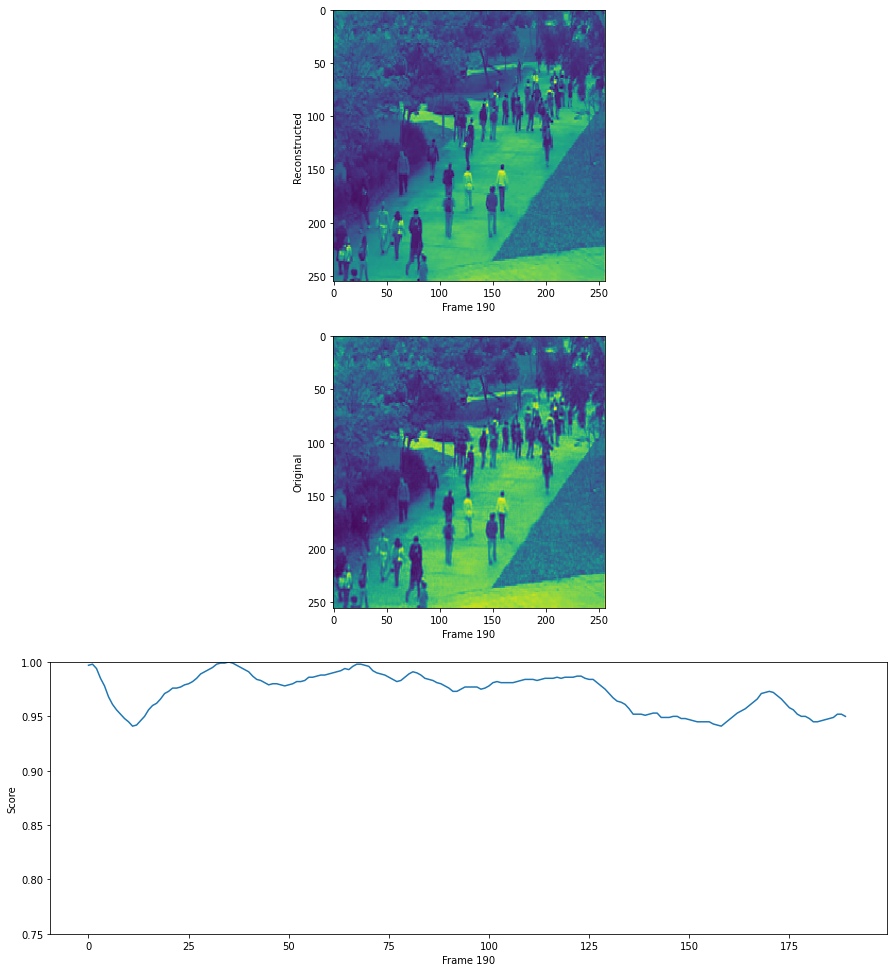

In [ ]:
print('PLOT OF A SAMPLE TRAINING SCENE')
HTML(plot_combined(reconstructed_sequences_train, sequences_train, regularity_score_train, save = True, title = 'combined_train_video.mp4'))

In [ ]:
reconstructed_sequences_test, sequences_test, regularity_score_test = evaluate_single_test(recalculate_score = False)

Acquired Model
Acquired Single Test Data
Opened: /content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/test_score_matrix.pkl


PLOT OF A SAMPLE TEST SCENE


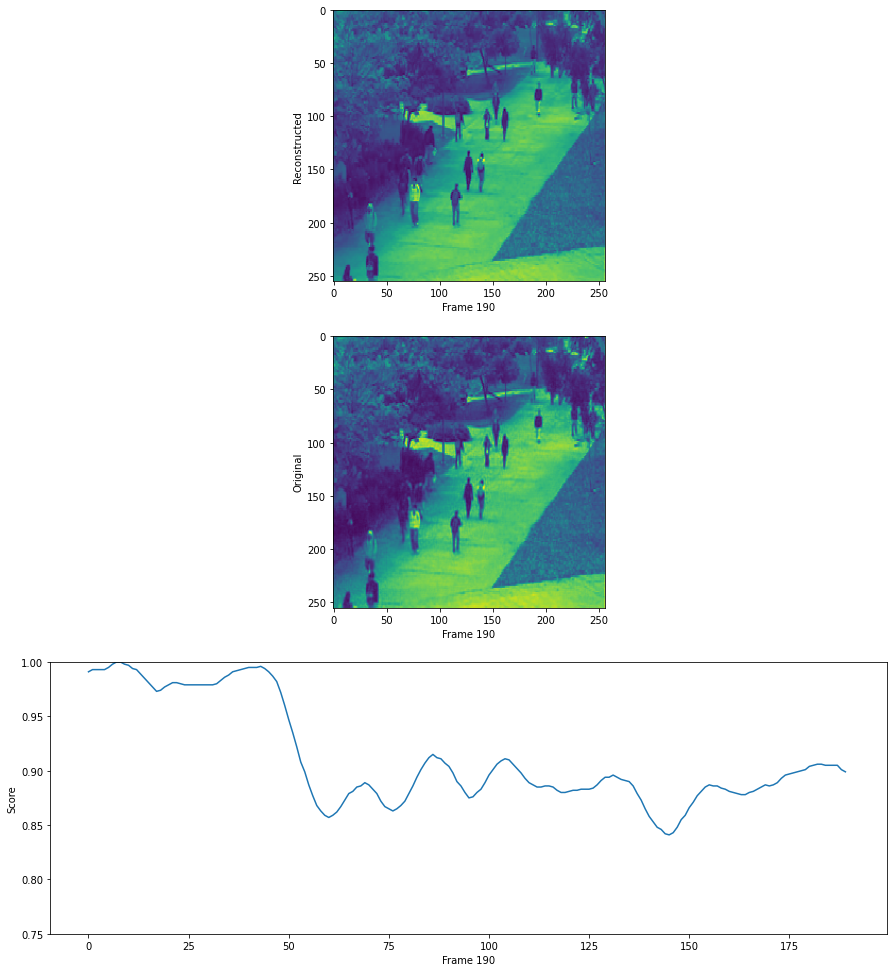

In [ ]:
print('PLOT OF A SAMPLE TEST SCENE')
HTML(plot_combined(reconstructed_sequences_test, sequences_test, regularity_score_test, save = True, title = 'combined_test_video.mp4'))

In [ ]:
# Plotting reconstructed sequences

# fig2 = plt.figure()
# plt.title('Reconstructed')

# ims_r = []
# for i in range (0,len(reconstructed_sequences),5):
#     for j in range (0,len(reconstructed_sequences[i]),5):
#       im_r = plt.imshow(reconstructed_sequences[i,j,:,:,0], animated = True)
#       ims_r.append([im_r])

# ani1 = animation.ArtistAnimation(fig2, ims_r, interval=100, blit=True, repeat = True,
#                                 repeat_delay=100)
# ani1.save(Config.VIDEO_PATH + "/reconstructed_sequences32.mp4")
# HTML(ani1.to_html5_video()) 

In [ ]:
# Plotting original sequences

# fig3 = plt.figure()
# plt.title('Original')

# ims = []
# for i in range (0,len(reconstructed_sequences),5):
#     for j in range (0,len(reconstructed_sequences[i]),5):
#       im = plt.imshow(sequences[i,j,:,:,0], animated = True)
#       ims.append([im])

# ani2 = animation.ArtistAnimation(fig3, ims, interval=100, blit=True, repeat = True,
#                                 repeat_delay=100)
# ani2.save(Config.VIDEO_PATH + "/original_sequences32.mp4")
# HTML(ani2.to_html5_video()) 

In [ ]:
# Plotting similarity score

# fig3 = plt.figure()
# plt.title('regularity score Sr(t)')
# plt.ylabel('regularity score Sr(t)')
# plt.xlabel('frame t')

# regularity_score.reshape(1,-1)

# x = np.arange(0, len(regularity_score), 1)
# line, = plt.plot(x, regularity_score)

# def animate(i):
#     line.set_ydata(regularity_score[0:i])  # update the data.
#     line.set_xdata(x[0:i])  # update the data.
#     return line,

# ani3 = animation.FuncAnimation(fig3, animate, interval=100, blit=True, repeat = True,
#                                 repeat_delay=100)

# HTML(ani3.to_html5_video()) 
# ####


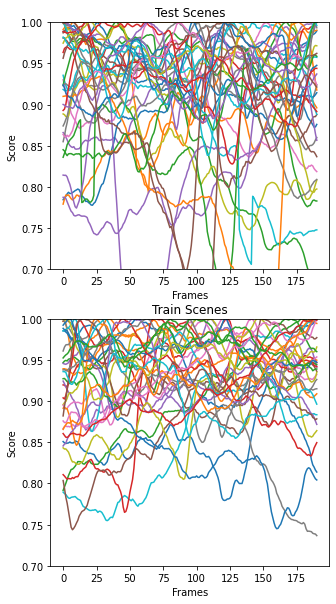

In [ ]:
# Open pickled train and test score matrices

with open("/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/train_score_matrix.pkl", "rb") as file:
  train_scores = pickle.load(file)

with open("/content/drive/My Drive/Machine Learning Project/UCSD_Anomaly_Dataset_v1p2/UCSDped1_2/test_score_matrix.pkl", "rb") as file:
  test_scores = pickle.load(file)

fig6, (ax1, ax2) = plt.subplots(2)

fig6.set_figheight(10)
fig6.set_figwidth(5)

ax1.set_title('Test Scenes')
ax1.set_ylabel('Score')
ax1.set_xlabel('Frames')
ax1.set_ylim([0.7,1])

ax2.set_title('Train Scenes')
ax2.set_ylabel('Score')
ax2.set_xlabel('Frames')
ax2.set_ylim([0.7,1])

x_test = np.arange(0, len(test_scores[0]), 1)
x_train = np.arange(0, len(train_scores[0]), 1)

for i in range(0,len(test_scores)):
  line1 = ax1.plot(x_test, test_scores[i])

for i in range(0,len(train_scores)):
  line2 = ax2.plot(x_train, train_scores[i])

fig6.savefig(Config.VIDEO_PATH + '/combined_scores_plot.png')
plt.show()

In [ ]:
test_scores_array = np.array(test_scores)
np.mean(test_scores_array[test_scores_array < 0.95])

0.8768275057754726

In [ ]:
train_scores_array = np.array(train_scores)
np.mean(train_scores_array[train_scores_array < 0.95])

0.8966791207185889